<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *

/home/mffang/workspace/Trajectory/FGP_2024
2024.10


In [93]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

import cmasher as cmr
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sns

import anndata as ad
import scanpy as sc
import scvelo as scv

import copy
from multiprocessing import Pool
import pickle
import tqdm

In [3]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '30'
legend_font = '24'
title_font = '36'

In [4]:
import rpy2
import rpy2.robjects as robjects

In [5]:
%load_ext rpy2.ipython

In [6]:
adata = ad.read("data/neuron.h5ad")
adata

AnnData object with n_obs × n_vars = 3060 × 23918
    obs: 'cell_type', '4sU', 'treatment', 'time', 'cell_name'
    var: 'gene_short_name', 'activity_genes'
    layers: 'new', 'spliced', 'total', 'unspliced'

In [14]:
## For R counts is gene by cell
counts = adata.X.toarray().T
celltype = np.array(adata.obs['time'])
true_t = np.array(adata.obs['time'],dtype=float)/60

In [7]:
Timepoints = [0,0.25,0.5,1,2]
color_palette = ["#b1cdd8", "#5f9da2", "#2a7986", "#0e3442"]
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Timepoints))

# Monocle 3

In [102]:
# Read the pseudotime CSV file
pseudotime_df = pd.read_csv("results/Neuron_monocle3_pseudotime.csv")
monocle3_pseudotime = np.array(pseudotime_df['Pseudotime'],dtype=float)

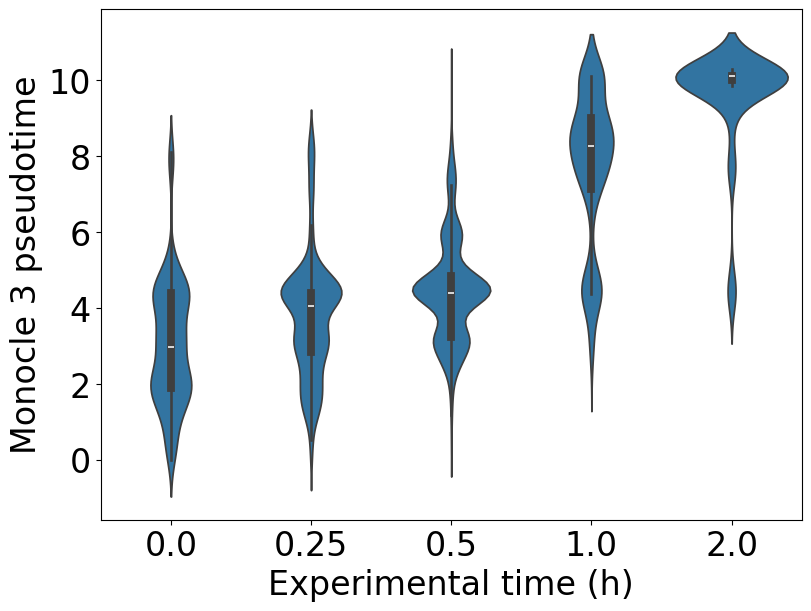

In [105]:
pos = [0,15,30,60,120]
t_values = []

for i, timepoint in enumerate(pos):
    # Get indices for the current timepoint
    idx = adata.obs["time"].isin([timepoint])   
    # Extract t values for the selected indices
    t_values.append(monocle3_pseudotime[idx])  # Get the corresponding t values for the current timepoint
    
data_ = pd.DataFrame({
    'timepoint': np.concatenate([[p] * len(vals) for p, vals in zip(pos, t_values)])/60,
    't_values': np.concatenate(t_values)
})

# Plot with seaborn violinplot
plt.figure(figsize=(8, 6))
sns.violinplot(data=data_, x='timepoint', y='t_values')
plt.xlabel("Experimental time (h)")
plt.ylabel("Monocle 3 pseudotime")
plt.show()

# Slingshot + tradeSeq

In [15]:
%%R -i celltype -i counts

suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(slingshot)
    library(scran)
    library(scater)
    library(igraph)
    library(RColorBrewer)
})

data <- SingleCellExperiment(assays = list(counts = counts))
data <- computeSumFactors(data, sizes = c(20, 40, 60, 80))
data <- logNormCounts(data)
var.fit <- modelGeneVar(data)
top.hvgs <- getTopHVGs(var.fit, n = 2000)
data <- runPCA(data, subset_row = top.hvgs)
rd1 <- reducedDim(data, "PCA")[, 1:2]

# Example: Adding cell type information if available
# Assuming `celltype` is a vector with labels for each cell
colData(data)$celltype <- celltype

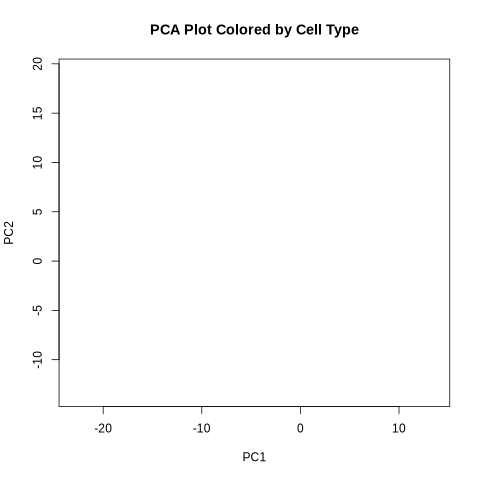

In [22]:
%%R

# Assuming `X_pca` is a matrix with PCA results and `celltype` is a factor or vector with cell type labels
# Generate colors using the Spectral palette
unique_celltypes <- unique(celltype)  # Get unique cell types
n_celltypes <- length(unique_celltypes)  # Count unique cell types

# Ensure there are enough colors; Spectral palette can handle up to 11 colors
# If there are more than 11 unique cell types, you can adjust the palette or cycle colors
if (n_celltypes > 11) {
    warning("More than 11 unique cell types detected; colors may repeat.")
}

# Use Spectral palette (up to 11 colors)
celltype_colors <- brewer.pal(min(n_celltypes, 11), "Spectral")

# Map `celltype` to colors
cell_colors <- setNames(celltype_colors, unique_celltypes)[celltype]

# Plot PCA with colors by cell type
plot(rd1, col = cell_colors, pch = 16, asp = 1,
     xlab = "PC1", ylab = "PC2", main = "PCA Plot Colored by Cell Type")

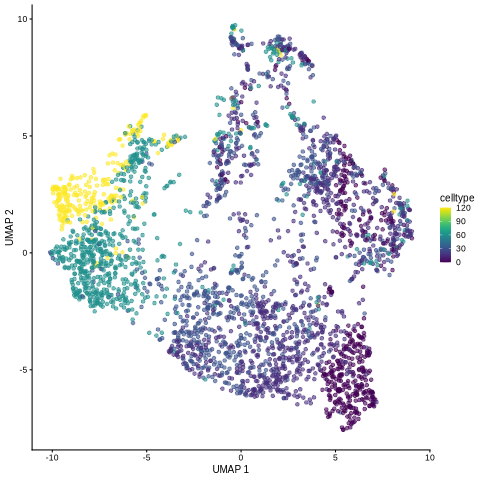

In [19]:
%%R 
data <- runUMAP(data, dimred = "PCA", n_dimred = 50, ncomponents = 2, spread = 2, min_dist = 0.1, n_neighbors = 10, metric = "cosine")

# Plot the clusters
plotReducedDim(data, dimred = "UMAP", colour_by = "celltype")

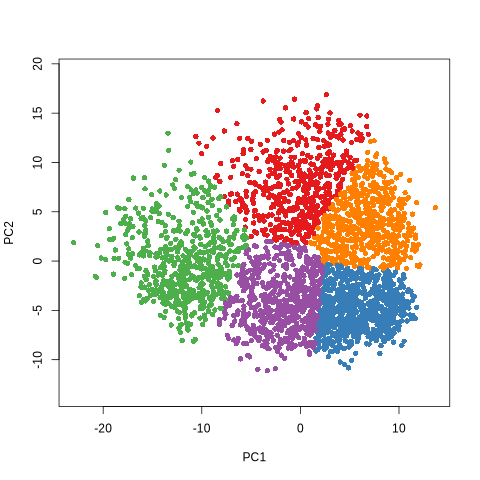

In [32]:
%%R
set.seed(0)
cl2 <- kmeans(rd1, centers = 5)$cluster
colData(data)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

## Set1: red blue green purple

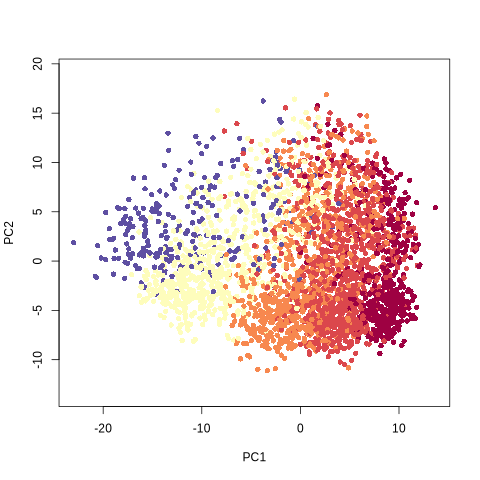

In [23]:
%%R -i true_t
# Create a continuous color ramp from the Spectral colormap
color_ramp <- colorRampPalette(brewer.pal(11, "Spectral"))

# Normalize true_t (or C) to [0, 1]
norm_true_t <- (true_t - min(true_t)) / (max(true_t) - min(true_t))

# Create a palette of 100 colors from the Spectral colormap
colors <- color_ramp(100)

# Map normalized true_t to the color palette using cut()
mapped_colors <- colors[cut(norm_true_t, breaks = 100)]

# Plot the reduced dimensions (rd) with colors based on continuous true_t
plot(rd1, col = mapped_colors, pch = 16, asp = 1)

In [33]:
%%R
# slingshot with the true start cluster provided
data <- slingshot(data, clusterLabels = 'kmeans', reducedDim = 'PCA', start.clus = 2)
colData(data)$slingshot

class: PseudotimeOrdering 
dim: 3060 2 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(3060): Cell-1 Cell-2 ... Cell-3059 Cell-3060
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):


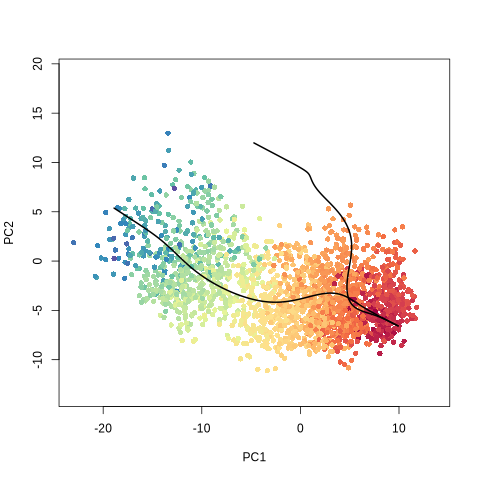

In [34]:
%%R
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(data$slingPseudotime_1, breaks=100)]

plot(reducedDims(data)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(data), lwd=2, col='black')

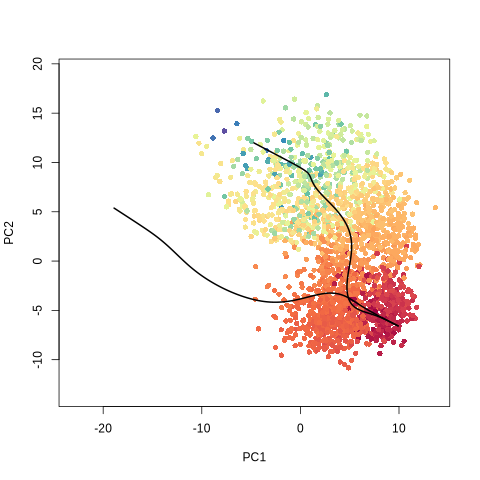

In [47]:
%%R
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(data$slingPseudotime_2, breaks=100)]

plot(reducedDims(data)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(data), lwd=2, col='black')

In [35]:
%%R

#pdf('principle_curve.pdf')
par(mar = c(4, 6, 0, 0))

weights = slingCurveWeights(sce)
weight = weights/rowSums(weights)
time1 = data$slingPseudotime_1
time1[is.na(time1)] = 0
time2 = data$slingPseudotime_2
time2[is.na(time2)] = 0

x_pca = reducedDims(data)$PCA

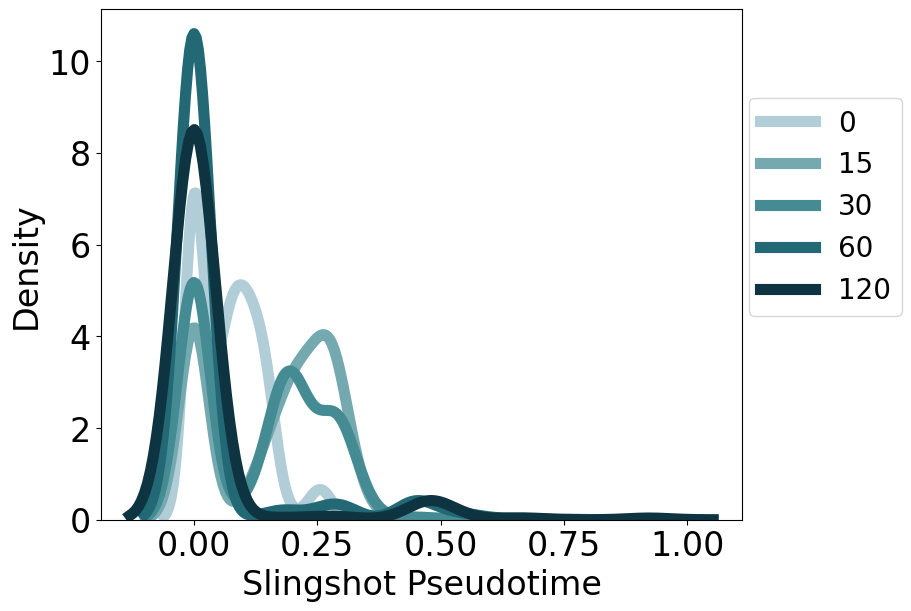

In [52]:
import seaborn as sns

time1 = robjects.r['time1']
time2 = robjects.r['time2']
weight = robjects.r['weight']

# Normalize time1
t = time1 / np.max(time1) * np.array(weight)[:,0] + time2 / np.max(time2) * np.array(weight)[:,1]

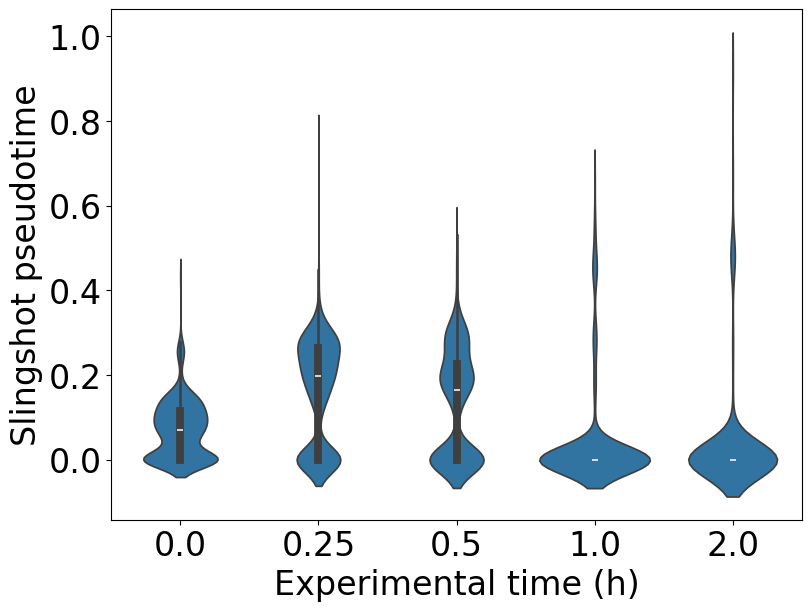

In [57]:
pos = [0,15,30,60,120]
t_values = []

for i, timepoint in enumerate(pos):
    # Get indices for the current timepoint
    idx = adata.obs["time"].isin([timepoint])   
    # Extract t values for the selected indices
    t_values.append(t[idx])  # Get the corresponding t values for the current timepoint
    
import seaborn as sns

# Combine data into a DataFrame for easy use with seaborn
import pandas as pd
data = pd.DataFrame({
    'timepoint': np.concatenate([[p] * len(vals) for p, vals in zip(pos, t_values)])/60,
    't_values': np.concatenate(t_values)
})

# Plot with seaborn violinplot
plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='timepoint', y='t_values')
plt.xlabel("Experimental time (h)")
plt.ylabel("Slingshot pseudotime")
plt.show()

# DPT

We follow this [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/trajectories/paga-paul15.html)

In [84]:
data = adata.copy()
data

AnnData object with n_obs × n_vars = 3060 × 23918
    obs: 'cell_type', '4sU', 'treatment', 'time', 'cell_name'
    var: 'gene_short_name', 'activity_genes'
    layers: 'new', 'spliced', 'total', 'unspliced'

In [85]:
sc.pp.recipe_zheng17(data, n_top_genes=2000)
sc.tl.pca(data, svd_solver="arpack")

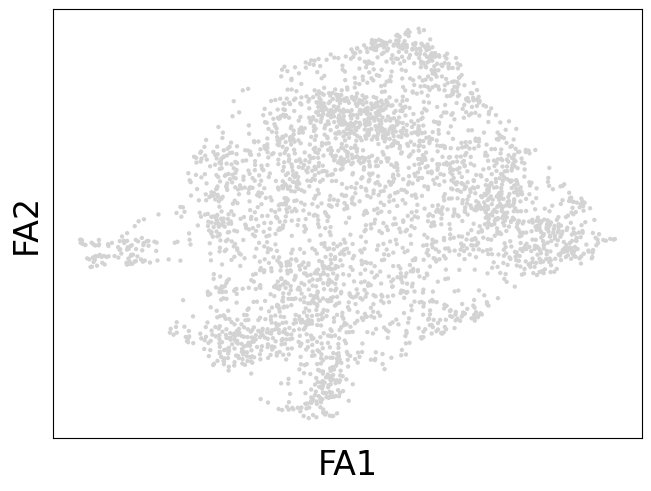

In [86]:
sc.pp.neighbors(data, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(data)

sc.tl.diffmap(data)
sc.pp.neighbors(data, n_neighbors=10, use_rep="X_diffmap")
sc.pl.draw_graph(data, legend_loc="on data")

In [87]:
sc.tl.leiden(data)
sc.tl.paga(data, groups="leiden")

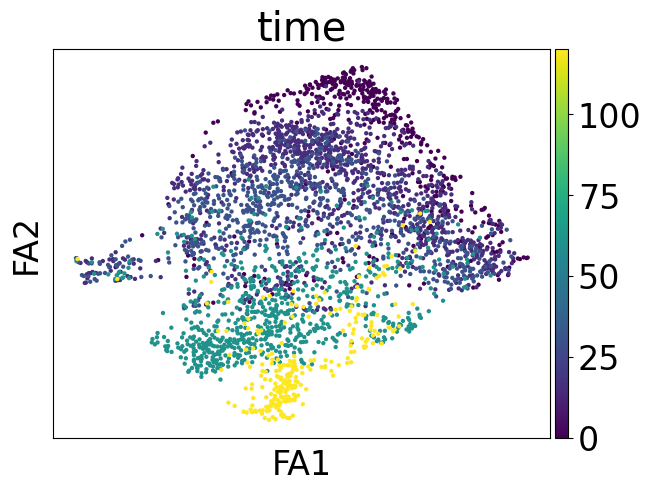

In [88]:
sc.pl.draw_graph(data, color=["time"], legend_loc="on data")

In [65]:
true_t = np.array(data.obs['time'],dtype=str)

np.where (true_t == '0')

(array([   2,    7,   11,   12,   18,   26,   53,   54,   61,   64,   77,
          97,   98,  112,  129,  132,  137,  141,  150,  151,  152,  158,
         162,  171,  194,  201,  220,  224,  236,  246,  251,  257,  269,
         272,  274,  283,  292,  302,  310,  323,  336,  338,  342,  345,
         349,  355,  365,  369,  370,  380,  384,  387,  398,  407,  413,
         417,  433,  437,  442,  444,  446,  477,  481,  483,  491,  497,
         498,  501,  507,  509,  527,  532,  534,  546,  548,  559,  574,
         579,  593,  597,  600,  601,  611,  614,  617,  643,  658,  659,
         669,  670,  684,  686,  722,  723,  728,  731,  734,  736,  744,
         760,  775,  779,  782,  801,  802,  805,  806,  820,  821,  823,
         825,  827,  832,  844,  846,  848,  849,  868,  873,  881,  882,
         884,  885,  886,  890,  893,  901,  902,  906,  909,  916,  930,
         932,  935,  941,  953,  955,  994,  995,  999, 1000, 1001, 1005,
        1007, 1008, 1016, 1020, 1027, 

In [89]:
data.uns["iroot"] = 2
sc.tl.dpt(data)

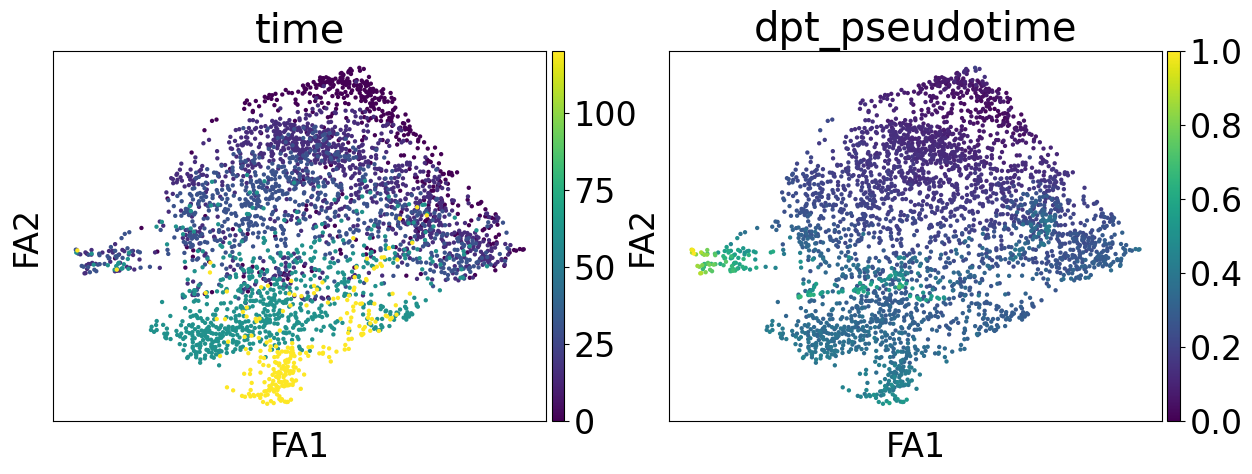

In [90]:
sc.pl.draw_graph(data, color=["time", "dpt_pseudotime"], legend_loc="on data")

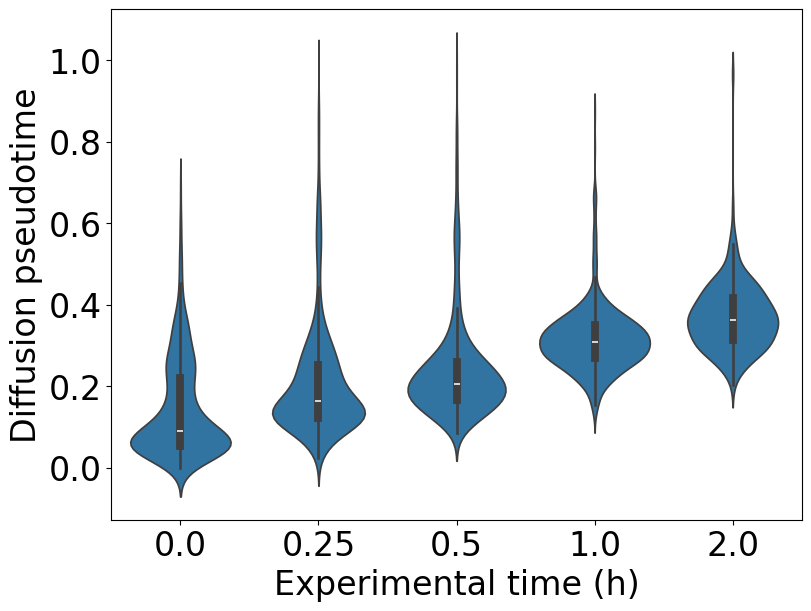

In [91]:
# Extract pseudotime
t = data.obs["dpt_pseudotime"]

pos = [0,15,30,60,120]
t_values = []

for i, timepoint in enumerate(pos):
    # Get indices for the current timepoint
    idx = data.obs["time"].isin([timepoint])   
    # Extract t values for the selected indices
    t_values.append(t[idx])  # Get the corresponding t values for the current timepoint
    
data_ = pd.DataFrame({
    'timepoint': np.concatenate([[p] * len(vals) for p, vals in zip(pos, t_values)])/60,
    't_values': np.concatenate(t_values)
})

# Plot with seaborn violinplot
plt.figure(figsize=(8, 6))
sns.violinplot(data=data_, x='timepoint', y='t_values')
plt.xlabel("Experimental time (h)")
plt.ylabel("Diffusion pseudotime")
plt.show()

# VeloVI

https://velovi.readthedocs.io/en/latest/tutorial.html

In [70]:
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import seaborn as sns

torch.set_num_threads(10)

In [71]:
vdata = adata.copy()
scv.pp.filter_and_normalize(vdata, min_shared_counts=30)
scv.pp.moments(vdata, n_pcs=30, n_neighbors=30)

Filtered out 19047 genes that are detected 30 counts (shared).
Normalized count data: spliced, unspliced.
Logarithmized X.


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [72]:
vdata = preprocess_data(vdata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [73]:
sc.tl.umap(vdata)

In [74]:
VELOVI.setup_anndata(vdata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(vdata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 374/500:  75%|███████▍  | 374/500 [02:30<00:50,  2.48it/s, loss=-48.8, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -45.311. Signaling Trainer to stop.


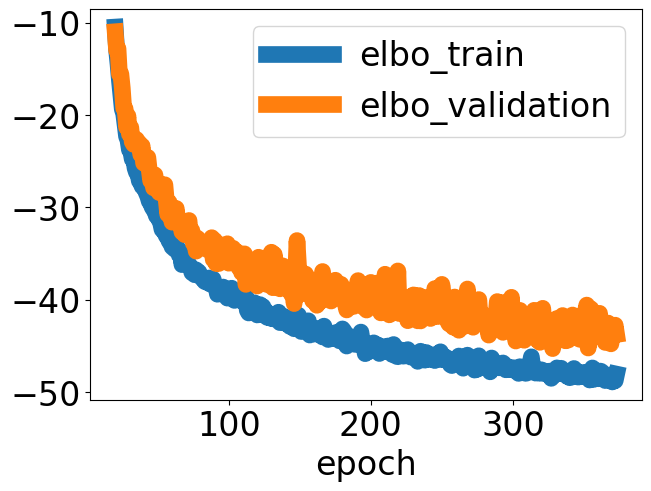

In [75]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [76]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(vdata, vae)

In [77]:
latent_time = vae.get_latent_time(n_samples=25)
np.shape(latent_time)

(3060, 51)

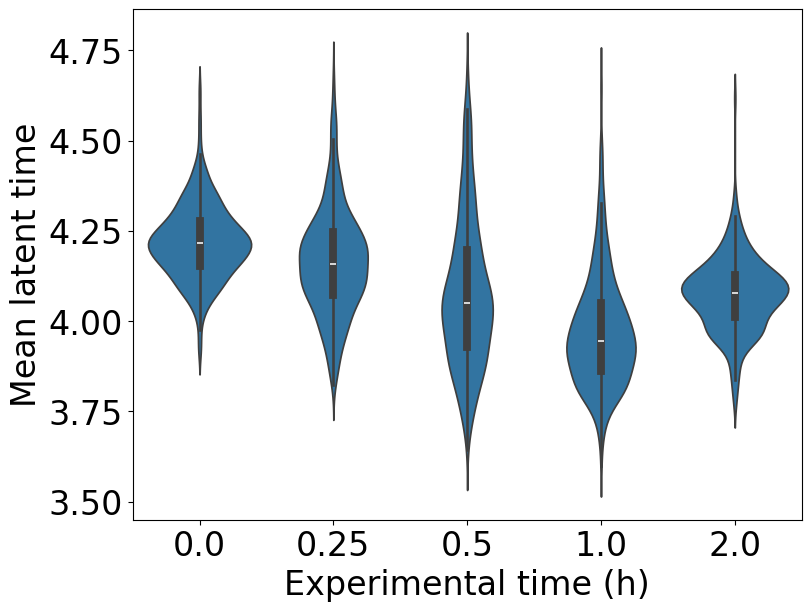

In [82]:
# Extract pseudotime
t = latent_time.mean(1)

pos = [0,15,30,60,120]
t_values = []

for i, timepoint in enumerate(pos):
    # Get indices for the current timepoint
    idx = adata.obs["time"].isin([timepoint])   
    # Extract t values for the selected indices
    t_values.append(t[idx])  # Get the corresponding t values for the current timepoint
    
data = pd.DataFrame({
    'timepoint': np.concatenate([[p] * len(vals) for p, vals in zip(pos, t_values)])/60,
    't_values': np.concatenate(t_values)
})

# Plot with seaborn violinplot
plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='timepoint', y='t_values')
plt.xlabel("Experimental time (h)")
plt.ylabel("Mean latent time")
plt.show()

In [79]:
scv.tl.velocity_graph(vdata)

computing velocity graph (using 1/88 cores)


  0%|          | 0/3060 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


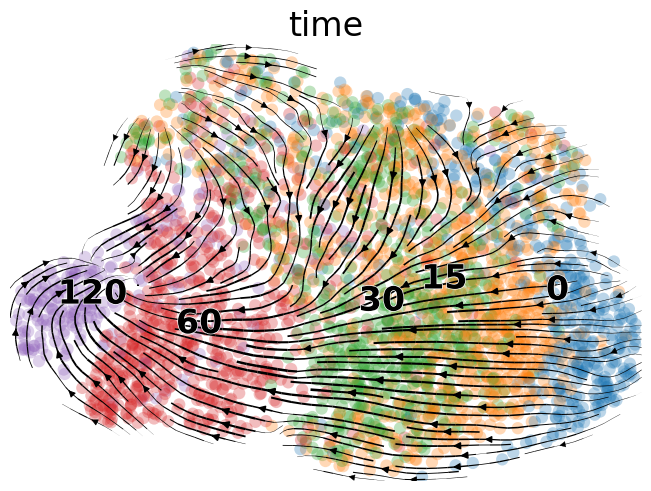

In [81]:
scv.pl.velocity_embedding_stream(vdata, basis='umap',color='time')